# Séries Temporais - Live Let's Data de 10/09/2021

In [2]:
# Para importar database do Kaggle, deve criar usuário no Kaggle e gerar o token de
# autenticação

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor

In [9]:
# vamos importar a base de produção de energia elétrica
df = pd.read_csv('petr4.csv', parse_dates=['date'])
df.tail()

,date,close
5669,2022-07-26,31.010000
5670,2022-07-27,31.350000
5671,2022-07-28,32.290001
5672,2022-07-29,34.150002
5673,2022-08-01,33.560001


In [10]:
df.set_index('date', inplace=True)

In [11]:
df

,close
date,
2000-01-03,5.875000
2000-01-04,5.550000
2000-01-05,5.494000
2000-01-06,5.475000
2000-01-07,5.500000
...,...
2022-07-26,31.010000
2022-07-27,31.350000
2022-07-28,32.290001


In [12]:
petrobras = df.resample('1M').mean()
petrobras.index = pd.to_datetime(petrobras.index)
petrobras.index = petrobras.index.map(lambda x: x.strftime('%Y-%m'))

In [13]:
# Quando começam e terminam os dados?
df.index.min(), df.index.max()

(Timestamp('2000-01-03 00:00:00'), Timestamp('2022-08-01 00:00:00'))

In [14]:
df.columns = ['preco']

<AxesSubplot:xlabel='date'>

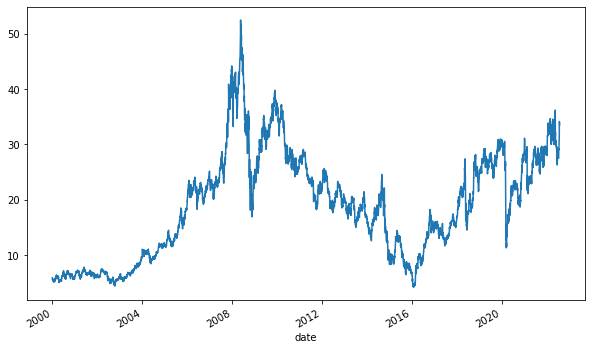

In [15]:
# Vamos dar uma olhada no gráfico de consumo x anos
df['preco'].plot(figsize=(10,6))

### Prevendo com ARIMA

notebook referencia:

https://www.kaggle.com/ludovicocuoghi/electric-production-forecast-lstm-sarima

In [16]:
df.isna().sum()

preco    0
dtype: int64

<Figure size 576x432 with 0 Axes>

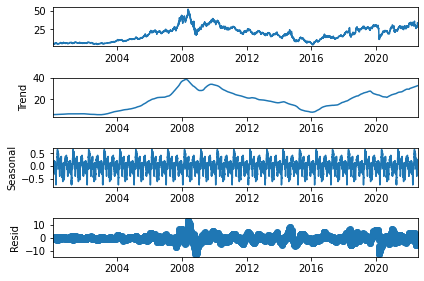

In [19]:
# Primeiro, vamos decompor a série pra avaliar tendência
# Sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df, model='additive', period=252, extrapolate_trend = 'freq')

fig = plt.figure(figsize=(8, 6))  
fig = resultado.plot()

#### Teste de estacionariedade

In [20]:
# Teste de estacionariedade. 
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['preco'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-2.223776072528246
p-valor:0.19772954948194316


#### Ou seja, a série não é realmente estacionária (p-valor >0.05, não podemos rejeitar a hipótese nula)

In [21]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=17.25 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=13236.378, Time=0.41 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=11645.099, Time=1.09 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=4.08 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=13234.310, Time=0.31 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=10961.087, Time=1.96 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=12.73 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=10.09 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=10959.369, Time=1.40 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=11644.204, Time=0.61 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=inf, Time=10.68 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=5.31 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=10961.077, Time=1.68 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=12.02 sec
 ARIMA(0,1,0)(2,1,0)[6] intercept   : AIC=10961.354, Tim

In [22]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX 
# (versão do arima com parametros para sazonalidade)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df,order=(0,1,0),  seasonal_order=(2,1,0,6))
resultado_sarimax = model.fit()

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65226D-01    |proj g|=  3.25914D-03


 This problem is unconstrained.



At iterate    5    f=  9.65225D-01    |proj g|=  4.11132D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   4.111D-06   9.652D-01
  F =  0.96522464520495099     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [23]:
# resultados do modelo SARIMAX(2,1,2)
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             preco   No. Observations:                 5674
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -5476.685
Date:                           Mon, 01 Aug 2022   AIC                          10959.369
Time:                                   21:35:09   BIC                          10979.297
Sample:                                        0   HQIC                         10966.309
                                          - 5674                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.6630      0.007    -98.544      0.000      -0.676      -0.650
ar.S.L12      -0.3380      0.006    -53.398      0.000      -0.350      -0.326
sigma2         0.4043      0.003    136.115      0.000       0.398       0.410
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):             32032.92
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               6.76   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = resultado_sarimax.get_prediction(start=-252)
predicao_media = predicoes.predicted_mean

In [25]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(26.684278003072375, 29.176725120884033)

In [26]:
predicao_media[0]

27.930501561978204

In [27]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

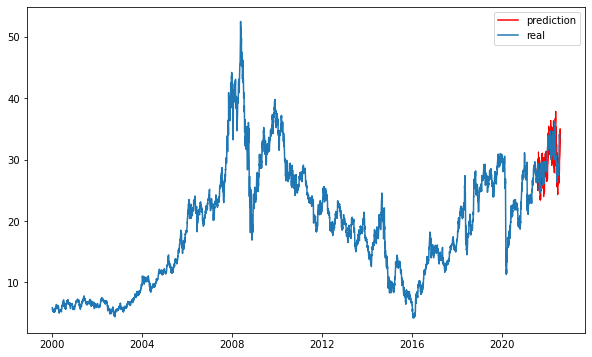

In [28]:
plt.figure(figsize=(10,6))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, df.values, label='real')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(df[-252:].values,predicao_media.values))
print(rmse_sarima)

0.9148447708558678


#### FORECAST COM ARIMA

In [30]:
# Forecast pra 12 values

forecast = resultado_sarimax.get_forecast(steps=252)
forecast_medio = forecast.predicted_mean
forecast_medio.size

/home/matheus/miniconda3/envs/econometria/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


252

In [31]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[5925], intervalo_acima_f[5925]

(-103.75708694267104, 395.86162121970347)

In [32]:
intervalo_confianca_forecast

,lower preco,upper preco
5674,33.201984,35.694431
5675,33.106425,36.631278
5676,32.966121,37.283166
5677,32.800407,37.785301
5678,33.091039,38.664320
...,...,...
5921,-99.332482,388.846982
5922,-100.436427,390.627831
5923,-101.476563,392.455640
5924,-102.019023,394.764569


In [33]:
forecast_medio[5925]

146.0522671385162

In [34]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

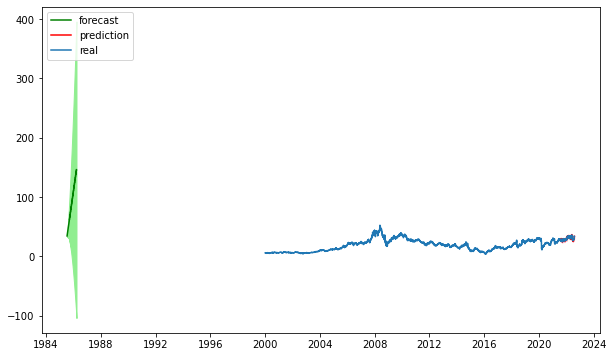

In [35]:
dates=np.asarray(df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates,df.values, label='real')
plt.legend(loc='upper left')
plt.show()

### Prevendo com XGBoost

In [36]:
df

,preco
date,
2000-01-03,5.875000
2000-01-04,5.550000
2000-01-05,5.494000
2000-01-06,5.475000
2000-01-07,5.500000
...,...
2022-07-26,31.010000
2022-07-27,31.350000
2022-07-28,32.290001


In [37]:
treino = df.loc[df.index <= '2016-12-31']
validacao = df.loc[df.index > '2016-12-31']

treino.shape, validacao.shape

((4285, 1), (1389, 1))

In [38]:
treino.index.min(), treino.index.max()

(Timestamp('2000-01-03 00:00:00'), Timestamp('2016-12-29 00:00:00'))

In [39]:
validacao.index.min(), validacao.index.max()

(Timestamp('2017-01-02 00:00:00'), Timestamp('2022-08-01 00:00:00'))

### Criando a variavel target e a lagged variable (que já é a consumo, certo?)

In [40]:
treino['preco']

date
2000-01-03     5.875
2000-01-04     5.550
2000-01-05     5.494
2000-01-06     5.475
2000-01-07     5.500
               ...  
2016-12-23    14.240
2016-12-26    14.420
2016-12-27    14.410
2016-12-28    14.780
2016-12-29    14.870
Name: preco, Length: 4285, dtype: float64

In [ ]:
treino['preco'].shift(-1)

DATE
1985-01-01     70.6720
1985-02-01     62.4502
1985-03-01     57.4714
1985-04-01     55.3151
1985-05-01     58.0904
                ...   
2016-08-01    102.7637
2016-09-01     91.4867
2016-10-01     92.8900
2016-11-01    112.7694
2016-12-01         NaN
Name: producao, Length: 384, dtype: float64

In [ ]:
treino['target'] = treino['preco'].shift(-1)
treino.head()

F:\leon\venvs\live02_series_temporais\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,producao,target
DATE,,
1985-01-01,72.5052,70.6720
1985-02-01,70.6720,62.4502
1985-03-01,62.4502,57.4714
1985-04-01,57.4714,55.3151
1985-05-01,55.3151,58.0904


In [ ]:
treino.tail()

,producao,target
DATE,,
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694
2016-12-01,112.7694,NaN


In [ ]:
treino = treino.dropna()
treino.tail()

,producao,target
DATE,,
2016-07-01,114.5397,115.5159
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694


In [ ]:
validacao['target'] = validacao['preco'].shift(-1)
validacao.head()

F:\leon\venvs\live02_series_temporais\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,producao,target
DATE,,
2017-01-01,114.8505,99.4901
2017-02-01,99.4901,101.0396
2017-03-01,101.0396,88.3530
2017-04-01,88.3530,92.0805
2017-05-01,92.0805,102.1532


In [ ]:
validacao.tail()

,producao,target
DATE,,
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212
2017-12-01,114.7212,129.4048
2018-01-01,129.4048,NaN


In [ ]:
validacao = validacao.dropna()
validacao.tail()

,producao,target
DATE,,
2017-08-01,108.9312,98.6154
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212
2017-12-01,114.7212,129.4048


In [ ]:
X_treino = treino.loc[:, ['preco']].values
y_treino = treino.loc[:, ['target']].values
X_validacao = validacao.loc[:, ['preco']].values
y_validacao = validacao.loc[:, ['target']].values

X_treino.shape, y_treino.shape, X_validacao.shape, y_validacao.shape

((383, 1), (383, 1), (12, 1), (12, 1))

In [ ]:
modelo_xgb_um_dia = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
modelo_xgb_um_dia.fit(X_treino, y_treino)

In [ ]:
ultima_linha = treino.iloc[-1]
ultima_linha['preco']

In [ ]:
ultimo_valor_treino = np.array([ultima_linha['preco']])

In [ ]:
predicao = modelo_xgb_um_dia.predict(ultimo_valor_treino)
predicao

In [ ]:
X_validacao[0]

In [ ]:
mean_squared_error(X_validacao[0], predicao)